# GloFAS - Attributes from meteorology
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 30-10-2024*<br>

**Introduction:**<br>
This notebook creates the climate indices as static attributes for the headwater catchments in the dataset used to develop the *parameter learning* framework in LISFLOOD-OS.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# import geopandas as gpd
from tqdm.notebook import tqdm
from datetime import datetime
# from shapely.geometry import Point
import yaml

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cf
from typing import Union, Dict, List, Tuple, Optional

In [4]:
def duration_indices(mask: pd.DataFrame) -> pd.Series:
    """
    Calculate the mean duration of meteorological extremes for each column in the mask DataFrame.

    This function assumes that the input DataFrame 'mask' contains boolean-like data (0s and 1s),
    where a 1 indicates the occurrence of a meteorological extreme and a 0 indicates no extreme.
    The function computes the mean duration of continuous sequences of 1s (extreme events) for
    each column, with the duration expressed in days.

    Parameters:
    -----------
    mask : pd.DataFrame
        A DataFrame with boolean-like values (0s and 1s), where the index represents time (as a
        DateTimeIndex) and each column corresponds to a different location or measurement.

    Returns:
    --------
    pd.Series
        A Series containing the mean duration of extreme events for each column in the mask
        DataFrame. The index of the Series corresponds to the columns of the input DataFrame.
    """
    
    duration = pd.Series(index=mask.columns, dtype=float)
    
    mask_diff = mask.astype(int).diff(axis=0)
    mask_diff.iloc[0] = mask.iloc[0].astype(int)
    for col in mask.columns:
        starts = mask_diff[mask_diff[col] == 1].index
        ends = mask_diff[mask_diff[col] == -1].index
        if len(starts) > len(ends):
            ends = ends.append(mask_diff.index[[-1]])
        elif len(starts) < len(ends):
            starts = mask_diff.index[[0]].append(starts)
        if len(starts) == 0:
            duration.loc[col] = 0
        else:
            duration.loc[col] = np.mean((ends - starts) / np.timedelta64(1, 'D'))
        
    return duration

In [5]:
def plot_attributes(df: pd.DataFrame,
                    x: pd.Series,
                    y: pd.Series,
                    save: Optional[Union[Path, str]] = None,
                    **kwargs):
    """
    It creates maps (scatter plots) of the static attributes associated to specific points.

    Parameters:
    -----------
    df: pd.DataFrame
        table of attributes
    x: pd.Series
        coordinate X of the points in "df"
    y: pd.Series
        coordinate Y of the points in "df"
    save: optional, Path or str
        location where the plot will be saved. By default it is None and the plot won't be saved

    kwargs:
    -------
    figsize: List o Tuple
    ncols: int
    cmap: str
    alpha: float
    """

    # kwargs
    figsize = kwargs.get('figsize', (5, 4))
    ncols_max = kwargs.get('ncols', 3)
    cmap = kwargs.get('cmap', 'magma')
    alpha = kwargs.get('alpha', 1)
    s = kwargs.get('size', 5)
    extent = kwargs.get('extent', [-180, 180, -90, 90])
   
    proj = ccrs.PlateCarree()
    ncols, nrows = df.shape[1], 1
    if ncols > ncols_max:
        ncols, nrows = ncols_max, int(np.ceil(ncols / ncols_max))

    fig, axes = plt.subplots(ncols=ncols,
                             nrows=nrows,
                             figsize=(figsize[0] * ncols, figsize[1] * nrows),
                             subplot_kw={'projection': proj})
    for i, col in enumerate(df.columns):
        if nrows > 1:
            f, c = i // ncols, i % ncols
            ax = axes[f, c]
        else:
            c = i
            ax = axes[c]
        ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
        ax.set_extent(extent, crs=proj)
        sc = ax.scatter(x[df.index], y[df.index], cmap=cmap, c=df[col], s=s, alpha=alpha, label=col)
        cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', shrink=.5)
        ax.set_title(' '.join(col.split('_')))
        ax.axis('off');
    
    if c < ncols - 1:
        for c_ in range(c + 1, ncols):
            axes[f, c_].axis('off')

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

## Configuration

In [6]:
PATH = Path('/eos/jeodpp/data/projects/FLOODS-RIVER/LisfloodPL/nh_dataset')

## Data

### Catchments

In [14]:
catchments = pd.read_csv(PATH / 'attributes_casadje' / 'static_maps.csv', index_col='ID')
catchments.index = catchments.index.astype(int)

### Time series

In [18]:
# read time series
variables = ['tp_mean', '2t_mean', 'eT0_mean']
meteo = []
files = [file for file in (PATH / 'time_series').glob('*.nc') if int(file.stem) in catchments.index]
for file in files:
    ds = xr.open_dataset(file)[variables]
    ds = ds.assign_coords(ID=int(file.stem))
    meteo.append(ds)
meteo = xr.concat(meteo, dim='ID')
meteo = meteo.rename({'tp_mean': 'precip', '2t_mean': 'temp', 'eT0_mean': 'pet'})

# compute precipitation as snowfall
meteo['snow'] = meteo['precip'].where(meteo['temp'] < 1, 0)

## Attributes

In [20]:
# average of all meteo variables
attrs = meteo.mean('date').to_pandas()
attrs.columns = [f'{col}_mean' for col in attrs.columns]
attrs.index.name = 'ID'

# indices
attrs['aridity'] = attrs.precip_mean / attrs.pet_mean
attrs['snow_frac'] = attrs.snow_mean / attrs.precip_mean
attrs['moisture_index'] = attrs.precip_mean - attrs.pet_mean
precip_monthly = meteo['precip'].resample({'date': 'ME'}).sum().groupby('date.month').mean()
precip_annual = meteo['precip'].resample({'date': 'YE'}).sum().mean('date')
attrs['seasonality'] = ((precip_monthly.max('month') - precip_monthly.min('month')) / precip_annual).to_pandas()
avg_monthly_temp = meteo['temp'].groupby('date.month').mean()
attrs['temp_gradient'] = (avg_monthly_temp.max('month') - avg_monthly_temp.min('month')).to_pandas()

In [21]:
# extreme events
extremes = {
    'precip': {
        'high': 20, # mm
        'low': 1 # mm
    },
    'temp': {
        'high': 30, # °C
        'low': 0 # °C
    }
}

for var, dct in extremes.items():
    for key, value in dct.items():
        if key == 'high':
            mask = meteo[var] > value
        elif key == 'low':
            mask = meteo[var] < value
        attrs[f'{var}_{key}_freq'] = mask.sum('date') / len(meteo.date)
        attrs[f'{var}_{key}_dur'] = duration_indices(mask.to_pandas().transpose())

In [ ]:
# # high and dry precipitation indices
# precip_extremes = {
#     'high': 20, # mm
#     'low': 1 # mm
# }
# for key, value in precip_extremes.items():
#     if key == 'high':
#         mask_precip = meteo['precip'] > value
#     elif key == 'low':
#         mask_precip = meteo['precip'] < value
#     attrs[f'{key}_precip_freq'] = mask_precip.sum('date') / len(meteo.date)
#     attrs[f'{key}_precip_dur'] = duration_precip_indices(mask_precip.to_pandas().transpose())

# # high and dry precipitation indices
# temp_extremes = {
#     'high': 30, # °C
#     'low': 0 # °C
# }
# for key, value in temp_extremes.items():
#     if key == 'high':
#         mask_temp = meteo['temp'] > value
#     elif key == 'low':
#         mask_temp = meteo['temp'] < value
#     attrs[f'{key}_temp_freq'] = mask_temp.sum('date') / len(meteo.date)
#     attrs[f'{key}_temp_dur'] = duration_precip_indices(mask_temp.to_pandas().transpose())

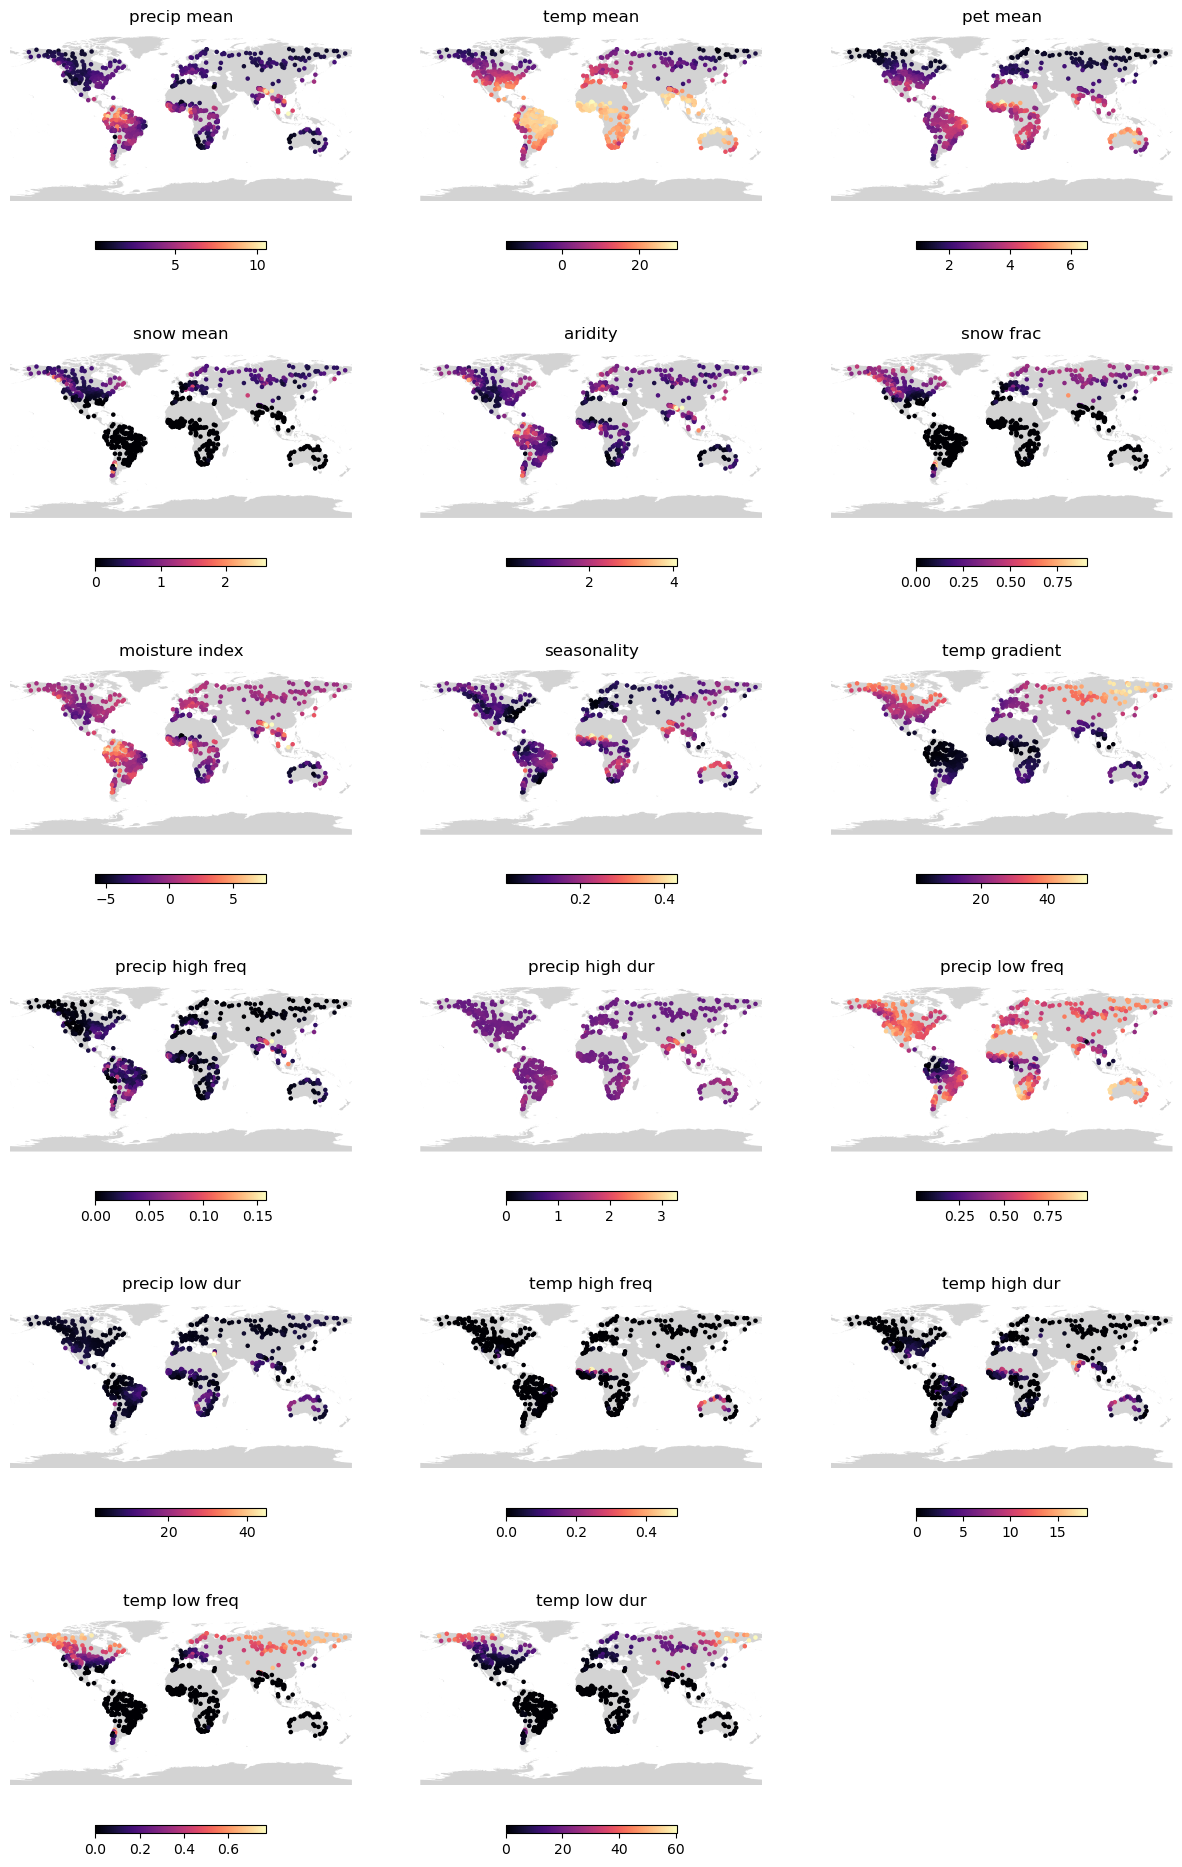

In [22]:
plot_attributes(
    attrs, 
    catchments.lon,
    catchments.lat,
    save=PATH / 'attributes_casadje' / 'maps_climate_indices.jpg'
)

In [23]:
# export
attrs.sort_index(axis=1).to_csv(PATH / 'attributes_casadje' / 'climate_indices.csv', float_format='%.6f')